In [3]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

## Group Assignment
### Team Number: 05
### Team Member Names: James Begin, Jonathan Wen, Emily Qi
### Team Strategy Chosen: Market Meet

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.

# Introduction 
The goal of the market "meet" portfolio is to match the returns of the average of the TSX60 and S&P500 indices as closely as possibly. To do this, we look at various indicators that can provide insight into a stock's ability to match market returns. Below are the factors we plan to take into account while constructing our portfolio:  
- Volume
- Price
- (find a name for this) Score
- Market Cap
- Earnings and Dividend Dates
- Fund/Institutional Holdings  

## Filtering
First, we ignore any delisted stocks, or non-US and Canadian Stocks, then filter by average monthly volume:
  



In [4]:
tickers = pd.read_csv('Tickers_Example.csv')
tickerlist = [tickers.columns[0]]
tickerlist += [i for i in tickers.iloc[:,0]]
startdate = '2023-10-01'
enddate = '2024-09-30'
stockdata = yf.download(tickerlist, start=startdate, end=enddate)
delisted = list(yf.shared._ERRORS.keys())
for i in delisted:
    tickerlist.remove(i)
    
exchangelist = ['NMS', 'NYQ', 'TOR']
minprice = 5
minvolume = 100000
mincap = 1000000000

for ticker in tickerlist:
    t = yf.Ticker(ticker)
    hist = t.history(start=startdate, end=enddate, period='1mo')
    inf = t.fast_info
    if ((t.get_history_metadata())['exchangeName'] not in exchangelist
            or hist['Volume'].mean() < minvolume 
            or hist['Close'].mean() < minprice
            or inf['market_cap'] > mincap):
        tickerlist.remove(ticker)    

[*********************100%***********************]  41 of 41 completed

4 Failed downloads:
['RTN', 'MON', 'AGN', 'CELG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


## Earnings Dates and Dividends
The period surrounding Earnings Dates, and Dividend Dates typically bring about higher volatility as investors and speculators buy and sell, hoping to take advantage of upcoming news and guidance. Below we illustrate some of the effects of Earnings/Corporate Announcements on volatility.


<BarContainer object of 2 artists>

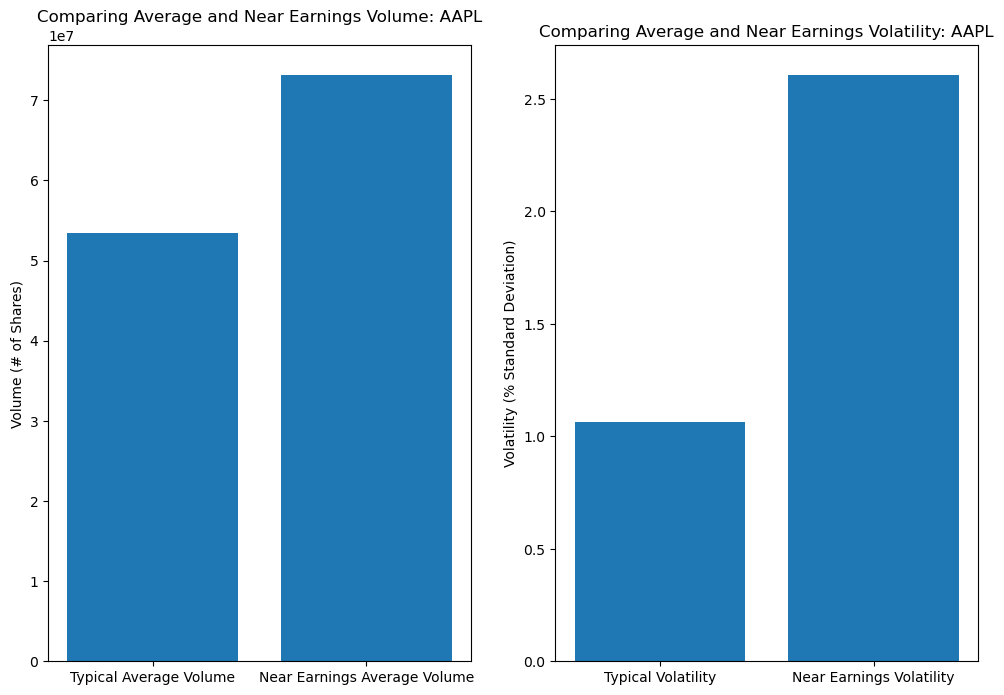

In [5]:
start1='2023-10-01'
end1='2023-11-01'
start2='2024-04-24'
end2='2024-05-05'
voldata = stockdata.loc[:, 'Volume']
plot1 = voldata.loc[start1:end1, 'AAPL'].mean()
plot2 = voldata.loc[start2:end2, 'AAPL'].mean()
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12, 8)
ax1.set_title("Comparing Average and Near Earnings Volume: AAPL")
ax1.set_ylabel('Volume (# of Shares)')
ax1.bar(['Typical Average Volume', 'Near Earnings Average Volume'], [plot1, plot2])

plot3 = stockdata.loc[:, 'Adj Close'].loc[start1:end1, 'AAPL'].pct_change().std() * 100
plot4 = stockdata.loc[:, 'Adj Close'].loc[start2:end2, 'AAPL'].pct_change().std() * 100
ax2.set_title("Comparing Average and Near Earnings Volatility: AAPL")
ax2.set_ylabel("Volatility (% Standard Deviation)")
ax2.bar(['Typical Volatility', 'Near Earnings Volatility'], [plot3, plot4])

Considering that we want to minimize volatility in order to meet the market, we filter out any stocks that have upcoming earnings or dividend dates:

In [6]:
#fetch the current and cutoff dates
currdate = (datetime.now()).date()
cutoff = (currdate + timedelta(days=14))

for ticker in tickerlist:
    #fetch the relevant dates
    cal = yf.Ticker(ticker).calendar
    #ensure that the yfinance has the dates we want
    div = (cal['Ex-Dividend Date'] if 'Ex-Dividend Date' in cal.keys() else cutoff)
    earnings = (cal['Earnings Date'][1] if len(cal['Earnings Date']) > 1 else cal['Earnings Date'][0])
    #check if there are events in the near future
    if ((earnings > currdate) and (cutoff > earnings)) or ((div > currdate) and (cutoff > div)):
        tickerlist.remove(ticker)
        

## (Placeholder) Score
Beta is a measure of volatility of a security or portfolio compared to the market. A beta of 1.0 indicates that a stock follows the market's returns exactly. We can take the average of the two indices and calculate the beta for each stock. However, Beta is only a measure of how sensitive a stock's returns are compared to the market. We could have a stock with beta close to 1.0, but with a low correlation, which is not what we are after. Considering we want to match the market's returns exactly, we use correlation to identify the strength of a relationship with an index.  
  
We calculate the rolling correlation with each stock to the market average, as this ensures we capture how the correlation might have changed over past (especially in recent months). Then, we find both the average correlation and standard deviation of the correlation. Using this, we identify how often the stock is highly correlated (over a certain correlation threshold). The result of this metric is a percentage.  
  
Then, we calculate how stable the correlation is for each stock. This is done by dividing the average correlation by the standard deviation of the correlation. This ensures that we also take into account, not only high correlation, but high correlation that doesn't change often.  
  
To calculate the final score, we find the reciprocal of the distance of each beta to 1.0 (this ensures that bigger values are always better) and multiply it by the percent of time the stock is highly correlated. and by how stable the correlation is.  

  
We can calculate beta using the formula (Covariance(Individual Returns, Market Returns)) / (Variance(Market Returns))

In [65]:
tsx = yf.Ticker('XIU.TO')
sp500 = yf.Ticker('SPY')
indices = pd.DataFrame()
indices['tsxprice'] = yf.download('XIU.TO', start=startdate, end=enddate)['Adj Close']
indices['spprice'] = yf.download('SPY', start=startdate, end=enddate)['Adj Close']
avg_index = indices.mean(axis=1)
ind_closepct = avg_index.pct_change(fill_method=None)

beta_dict = {}
closedata = stockdata.loc[:, 'Adj Close']


indvar = ind_closepct.var()

scores = {}

#calculate beta for each stock
for ticker in tickerlist:
    #prevent any mismatched indexes
    common = closedata[ticker].index.intersection(avg_index.index)
    closepct = closedata.loc[common, ticker].pct_change(fill_method=None)
    #calculate beta with respect to TSX and S&P Average
    beta = closepct.cov(ind_closepct) / indvar
    
    rolling_correlation = closepct.rolling(window=7).corr(ind_closepct)
    
    
    correlation_std = rolling_correlation.std()
    correlation_mean = rolling_correlation.mean()
    
    correlation_pct = (rolling_correlation > 0.8).mean() * 100
    
    consistency = correlation_mean / (correlation_std if correlation_std != 0 else 0.0001)
    
    score = (1 / abs(1.0-beta)) * correlation_pct * consistency
    
    scores[ticker] = score

    
for t in sorted(scores, key=scores.get, reverse=True):
     
    print(t, scores[t])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

QCOM 75.01740434920445
AMZN 74.108657907291
CAT 50.89545801634379
SHOP.TO 34.79712631168037
ACN 29.751024968010043
BK 23.58273625919922
BB.TO 11.308569190205354
UPS 10.040863341030091
TD.TO 8.68575644898243
BA 6.619121638322659
PFE 3.600683791657266
PM 2.742693204051148
BMY 1.2988339030442324
MRK 1.146828332269709
ABBV 0.4277014878150411
UNH 0.044810295733164904
LMT -0.1875164647878429


The stocks sorted by closeness to 1.0 are: 
LMT -0.1875164647878429
UNH 0.044810295733164904
ABBV 0.4277014878150411
MRK 1.146828332269709
BMY 1.2988339030442324
PM 2.742693204051148
PFE 3.600683791657266
BA 6.619121638322659
TD.TO 8.68575644898243
UPS 10.040863341030091
BB.TO 11.308569190205354
BK 23.58273625919922
ACN 29.751024968010043
SHOP.TO 34.79712631168037
CAT 50.89545801634379
AMZN 74.108657907291
QCOM 75.01740434920445


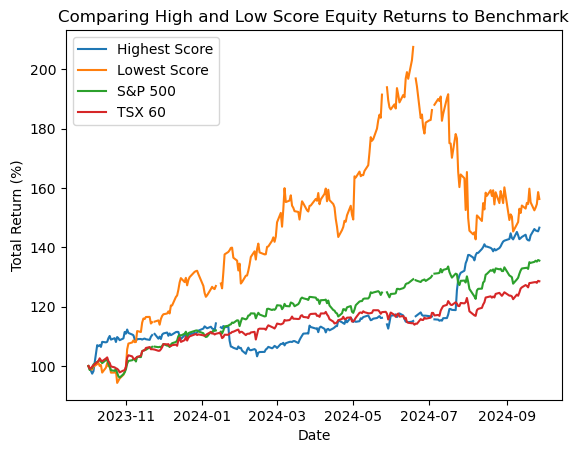

In [69]:
scores_sorted = []
print('The stocks sorted by closeness to 1.0 are: ')
for t in sorted(scores, key=scores.get, reverse=False):
    scores_sorted.append(t) 
    print(t, scores[t])

fig, ax = plt.subplots()
ax.set_title("Comparing High and Low Score Equity Returns to Benchmark")
ax.set_xlabel("Date")
ax.set_ylabel("Total Return (%)")

ax.plot(closedata[scores_sorted[0]] / (closedata[scores_sorted[0]]).values[0] * 100, label='Highest Score')
ax.plot(closedata[scores_sorted[-1]] / (closedata[scores_sorted[-1]]).values[0] * 100, label='Lowest Score')
ax.plot(indices['spprice'] / indices['spprice'].values[0] * 100, label='S&P 500')
ax.plot(indices['tsxprice'] / indices['tsxprice'].values[0] * 100, label='TSX 60')
ax.legend(loc='best')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Date
2023-10-02 00:00:00+00:00    False
2023-10-03 00:00:00+00:00    False
2023-10-04 00:00:00+00:00    False
2023-10-05 00:00:00+00:00    False
2023-10-06 00:00:00+00:00    False
                             ...  
2024-09-23 00:00:00+00:00    False
2024-09-24 00:00:00+00:00    False
2024-09-25 00:00:00+00:00    False
2024-09-26 00:00:00+00:00    False
2024-09-27 00:00:00+00:00    False
Length: 250, dtype: bool
Date
2023-10-02 00:00:00+00:00    False
2023-10-03 00:00:00+00:00    False
2023-10-04 00:00:00+00:00    False
2023-10-05 00:00:00+00:00    False
2023-10-06 00:00:00+00:00    False
                             ...  
2024-09-23 00:00:00+00:00    False
2024-09-24 00:00:00+00:00    False
2024-09-25 00:00:00+00:00    False
2024-09-26 00:00:00+00:00    False
2024-09-27 00:00:00+00:00    False
Length: 250, dtype: bool
Date
2023-10-02 00:00:00+00:00    False
2023-10-03 00:00:00+00:00    False
2023-10-04 00:00:00+00:00    False
2023-10-05 00:00:00+00:00    False
2023-10-06 00:00:00+00:00